<a href="https://colab.research.google.com/github/Rajmanandhar206/SHADOW_FOX/blob/main/Loan_Approval_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

# Load the dataset
df = pd.read_csv('loan_prediction.csv')

In [2]:
# Data Exploration
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types and missing values:")
print(df.info())
print("\nSummary statistics:")
print(df.describe(include='all'))

Dataset shape: (614, 13)

First few rows:
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0       

In [3]:
# Data Preprocessing

# Handle missing values
# For numerical columns, fill with median
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

<ipython-input-3-5d81e7816add>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [4]:
# For categorical columns, fill with mode
cat_cols = ['Gender', 'Married', 'Dependents', 'Self_Employed']
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)


<ipython-input-4-d9468ca71b18>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [5]:
# Convert 'Dependents' to numerical (replace '3+' with 3)
df['Dependents'] = df['Dependents'].replace('3+', 3).astype(int)

# Convert 'Credit_History' to categorical since it's binary
df['Credit_History'] = df['Credit_History'].astype('object')

# Convert target variable to binary
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})


In [6]:
# Feature Engineering
# Create Total Income feature
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# Create EMI feature (assuming 8% interest rate)
df['EMI'] = df['LoanAmount'] * 0.008 * (1 + 0.008)**df['Loan_Amount_Term'] / ((1 + 0.008)**df['Loan_Amount_Term'] - 1)

# Create Income to EMI ratio
df['Income_to_EMI'] = df['Total_Income'] / df['EMI']

# Drop Loan_ID as it's just an identifier
df.drop('Loan_ID', axis=1, inplace=True)

# Exploratory Data Analysis
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

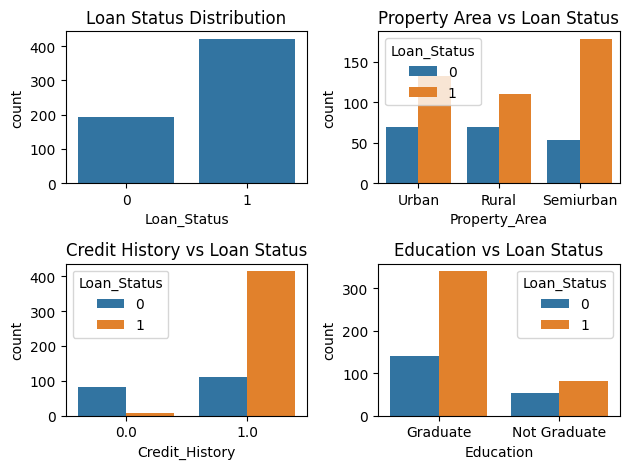

In [7]:
# Loan Status Distribution
plt.subplot(2, 2, 1)
sns.countplot(x='Loan_Status', data=df)
plt.title('Loan Status Distribution')

# Property Area vs Loan Status
plt.subplot(2, 2, 2)
sns.countplot(x='Property_Area', hue='Loan_Status', data=df)
plt.title('Property Area vs Loan Status')

# Credit History vs Loan Status
plt.subplot(2, 2, 3)
sns.countplot(x='Credit_History', hue='Loan_Status', data=df)
plt.title('Credit History vs Loan Status')

# Education vs Loan Status
plt.subplot(2, 2, 4)
sns.countplot(x='Education', hue='Loan_Status', data=df)
plt.title('Education vs Loan Status')

plt.tight_layout()
plt.show()

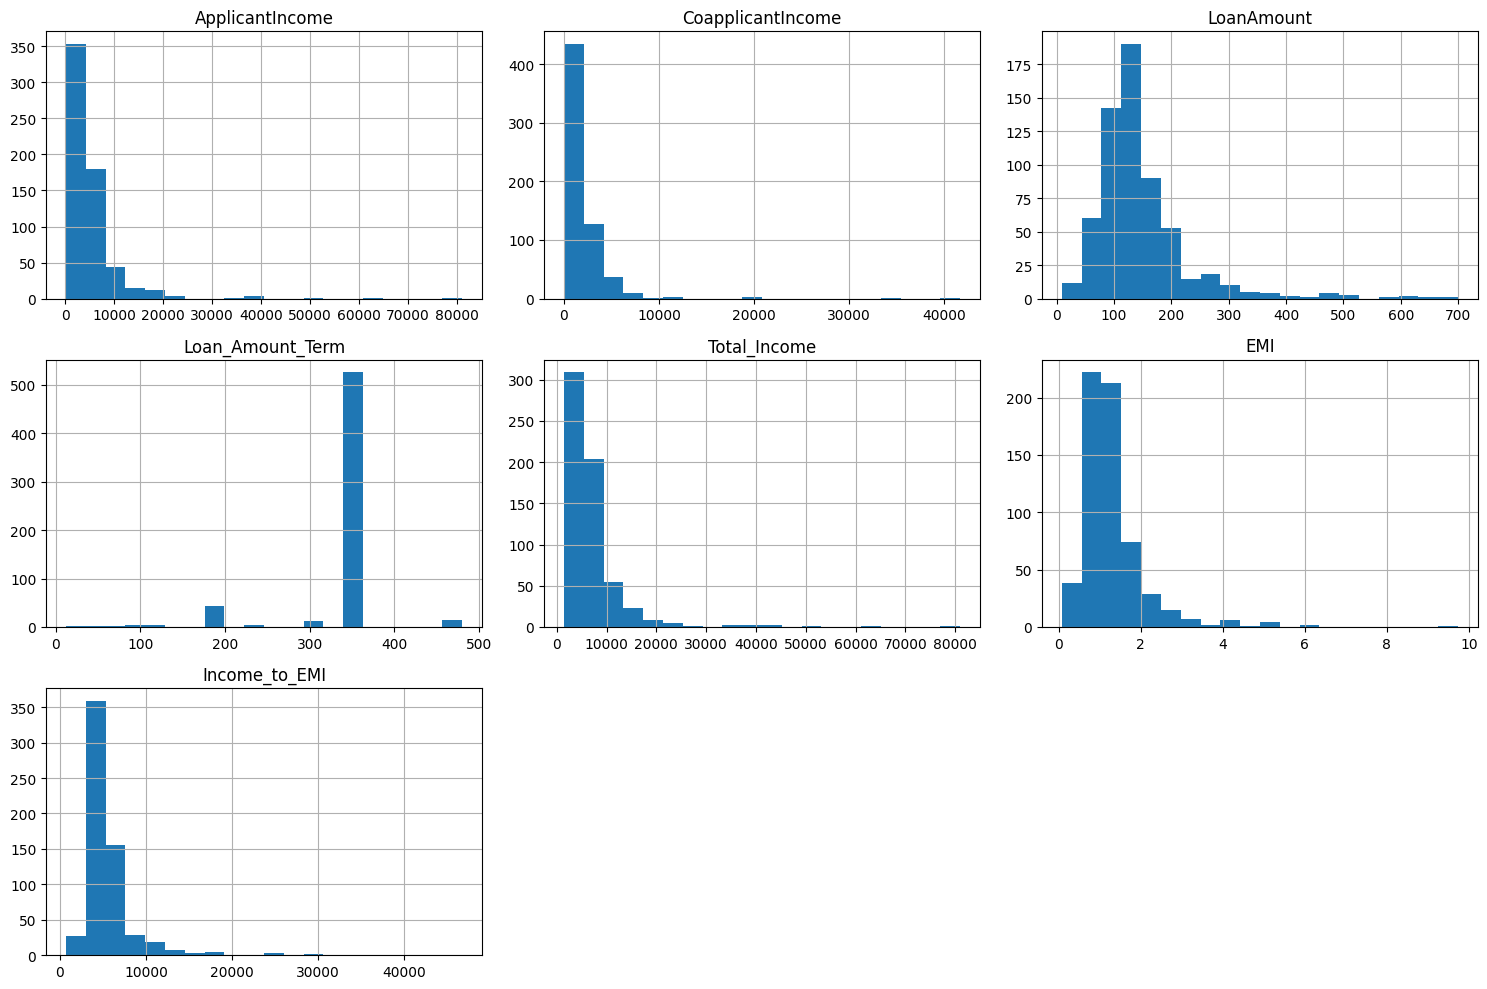

In [8]:
# Numerical features distribution
num_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
                'Total_Income', 'EMI', 'Income_to_EMI']
df[num_features].hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Prepare data for modeling
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']


In [9]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [10]:
# Define preprocessing steps
numeric_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
                   'Total_Income', 'EMI', 'Income_to_EMI']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
                        'Credit_History', 'Property_Area']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [11]:
# Create pipeline with model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier(random_state=42))])


In [13]:
# Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ApplicantIncome',
                                                                          'CoapplicantIncome',
                                                                          'LoanAmount',
                                                                          'Loan_Amount_Term',
                                                                          'Total_Income',
                                                                          'EMI',
                                                                          'Income_to_EMI']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(st...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'Married',
                                                                          'Dependents',
                                                                          'Education',
                                                                          'Self_Employed',
                                                                          'Credit_History',
                                                                          'Property_Area'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy')

In [14]:
# Best model
best_model = grid_search.best_estimator_
print("\nBest parameters:", grid_search.best_params_)

# Evaluate model
y_pred = best_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))



Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73        38
           1       0.85      0.98      0.91        85

    accuracy                           0.86       123
   macro avg       0.88      0.79      0.82       123
weighted avg       0.87      0.86      0.85       123


Confusion Matrix:
[[23 15]
 [ 2 83]]

Accuracy Score: 0.8617886178861789


In [15]:
# Feature Importance
# Get feature names after one-hot encoding
preprocessor.fit(X)
feature_names = numeric_features + list(best_model.named_steps['preprocessor']
                                      .named_transformers_['cat']
                                      .named_steps['onehot']
                                      .get_feature_names_out(categorical_features))

# Get feature importances
importances = best_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]


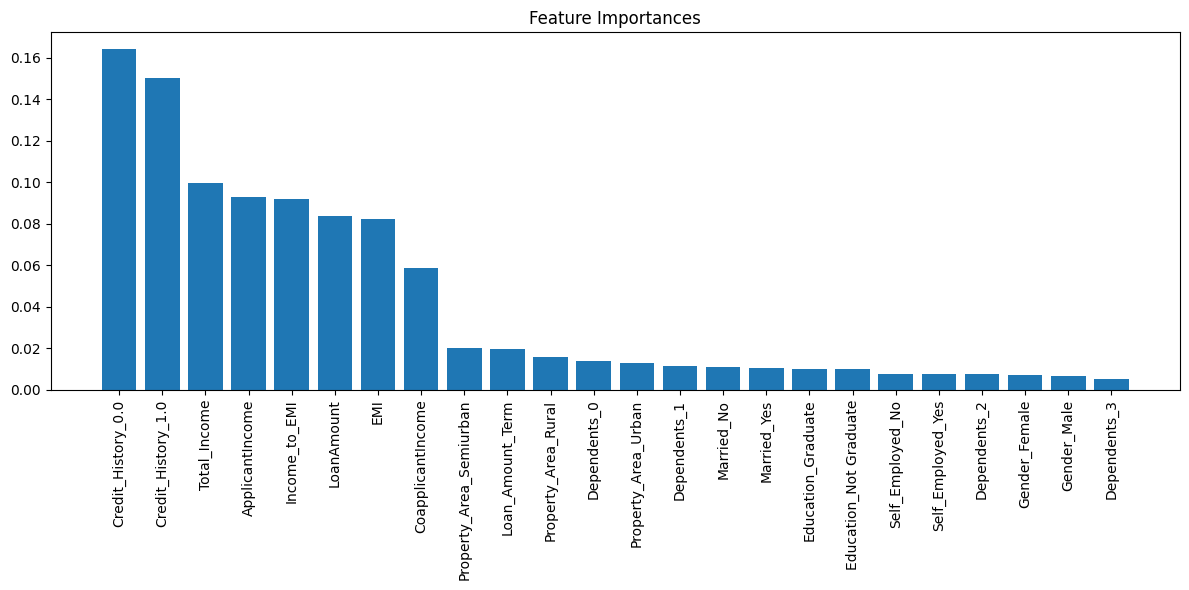

['loan_prediction_model.pkl']

In [16]:
# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Save the model (optional)
import joblib
joblib.dump(best_model, 'loan_prediction_model.pkl')


In [19]:
# Example prediction
example_data = pd.DataFrame({
    'Gender': ['Male'],
    'Married': ['Yes'],
    'Dependents': [2],
    'Education': ['Graduate'],
    'Self_Employed': ['No'],
    'ApplicantIncome': [5000],
    'CoapplicantIncome': [2000],
    'LoanAmount': [120],
    'Loan_Amount_Term': [360],
    'Credit_History': [1],
    'Property_Area': ['Semiurban']
})

# Add the missing engineered features to the example data
example_data['Total_Income'] = example_data['ApplicantIncome'] + example_data['CoapplicantIncome']
example_data['EMI'] = example_data['LoanAmount'] * 0.008 * (1 + 0.008)**example_data['Loan_Amount_Term'] / ((1 + 0.008)**example_data['Loan_Amount_Term'] - 1)
example_data['Income_to_EMI'] = example_data['Total_Income'] / example_data['EMI']


prediction = best_model.predict(example_data)
print("\nExample Prediction:", "Approved" if prediction[0] == 1 else "Rejected")


Example Prediction: Approved
